In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from typing import List
import json
from statistics import mean
import random
random.seed(42)

rootpath = ".."

degree_sign = u'\N{DEGREE SIGN}'

In [130]:
result_filename = f"{rootpath}/results/result_data/transfer_results.json"

with open(result_filename, "r") as f:
    results_data = json.load(f)

ft_percents = results_data["options"]["ft_percents"]
shuffle_seeds = results_data["options"]["seeds"]
transfer_methods = ["weight_initialization_LSTMDense", "weight_initialization_AutoLSTM"]

In [137]:
# Create a subplots figure with two subplots and set title
x = [fp * 100 for fp in ft_percents]

# initialize the dataframe for pir values
keys = [building+tower+"_"+season for building in ["ESB", "Kissam"] for tower in ["1","2"] for season in ["summer", "fall"]]
pir_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
pir_df['index'] = keys
pir_df.set_index("index", inplace=True)


def calcPir(base_error, transfer_error):
    if base_error == 0: raise ValueError("Base error is 0")
    return (base_error - transfer_error) / base_error

tm = 'weight_initialization_AutoLSTM'

for from_key in keys:
    for to_key in keys:

        if to_key == from_key: pir_df.loc[to_key, from_key] = 0
        try:
            base_mae = results_data[tm][to_key]["base"]["mae"]

            # # AVERAGE MAE METHOD
            avgm = [0.0] * len(ft_percents)
            
            for i, ft in enumerate([f"ft{int(fp * 100)}" for fp in ft_percents]):
                print(tm, from_key, to_key, ft, base_mae)
                print(results_data[tm][from_key][to_key][ft]["mae"])
                if None in results_data[tm][from_key][to_key][ft]["mae"]: raise ValueError("Skip this graph")
                avgm[i] = mean(results_data[tm][from_key][to_key][ft]["mae"])
            
            pir_list = [calcPir(base_mae, x) for x in avgm]
            pir_df.loc[to_key, from_key] = max(pir_list)
            

            # # LOWEST MAE METHOD
            # min_mae_list = [0.0] * len(ft_percents)
            # for i, ft in enumerate([f"ft{int(fp * 100)}" for fp in ft_percents]):
            #     if None in results_data[tm][from_key][to_key][ft]["mae"]: raise ValueError("Skip this graph")
            #     min_mae_list[i] = min(results_data[tm][from_key][to_key][ft]["mae"])
            # pir_list = [calcPir(base_mae, x) for x in min_mae_list]
            # pir_df.loc[to_key, from_key] = max(pir_list)
            
        except: continue # in case of null values (transfers that have not been run yet)

weight_initialization_AutoLSTM ESB1_summer ESB1_summer ft0 7.92050981848776
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft0 6.064622373322284
[59.62255555626102, 59.62255555626102, 59.62255555626102, 59.62255555626102, 59.62255555626102]
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft20 6.064622373322284
[37.7482036268753, 29.272489082310237, 27.849316715867246, 31.276044617492897, 34.14995948819993]
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft40 6.064622373322284
[22.319039804310798, 22.206687462344718, 20.45046300903074, 21.867458760362616, 23.0102657030981]
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft60 6.064622373322284
[17.543452168813843, 18.044514960076576, 17.375276116743795, 17.53464963626224, 17.50644851326359]
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft80 6.064622373322284
[15.227432128616226, 15.066259336359096, 14.708972903641572, 15.149023570091158, 15.514112779270524]
weight_initialization_AutoLSTM ESB1_summer ESB2_summe

In [133]:
pir_df

,ESB1_summer,ESB1_fall,ESB2_summer,ESB2_fall,Kissam1_summer,Kissam1_fall,Kissam2_summer,Kissam2_fall
index,,,,,,,,
ESB1_summer,0,-0.420226,-0.05523,-0.42796,-0.026468,-0.417546,-0.08301,-0.551112
ESB1_fall,-1.495318,0,-1.870566,-0.016061,-0.448603,-0.088366,-0.636028,-0.077014
ESB2_summer,-1.623415,-0.330421,0,-0.341501,-0.046209,-0.373725,-0.094827,-0.454168
ESB2_fall,-1.141712,0.014157,-1.243465,0,-0.275555,-0.013737,-0.658525,-0.04928
Kissam1_summer,-0.382114,-0.47812,-0.193918,-0.445153,0,-0.238471,-0.006001,-0.202445
Kissam1_fall,-2.764705,-0.107338,-3.157323,-0.118455,-0.515245,0,-0.764938,0.060364
Kissam2_summer,-0.103054,-0.399527,-0.434839,-0.307143,0.055952,-0.174011,0,-0.114734
Kissam2_fall,-1.653305,-0.131847,-2.38627,-0.156315,-0.443172,0.044517,-0.698924,0


<Axes: ylabel='index'>

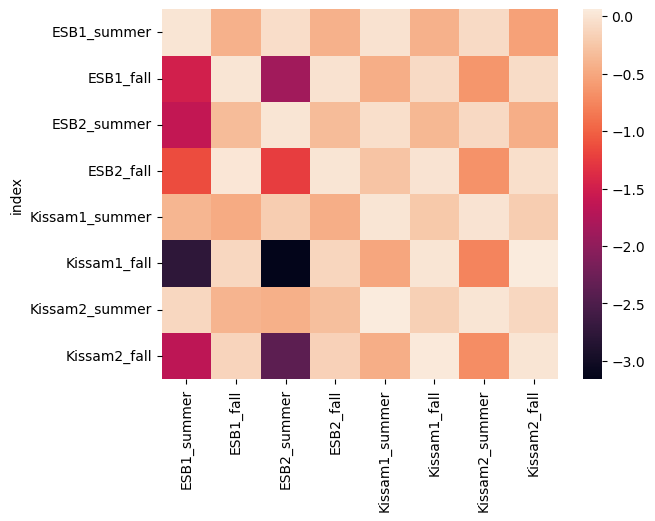

In [127]:
pir_df = pir_df.astype(float)
sns.heatmap(pir_df)

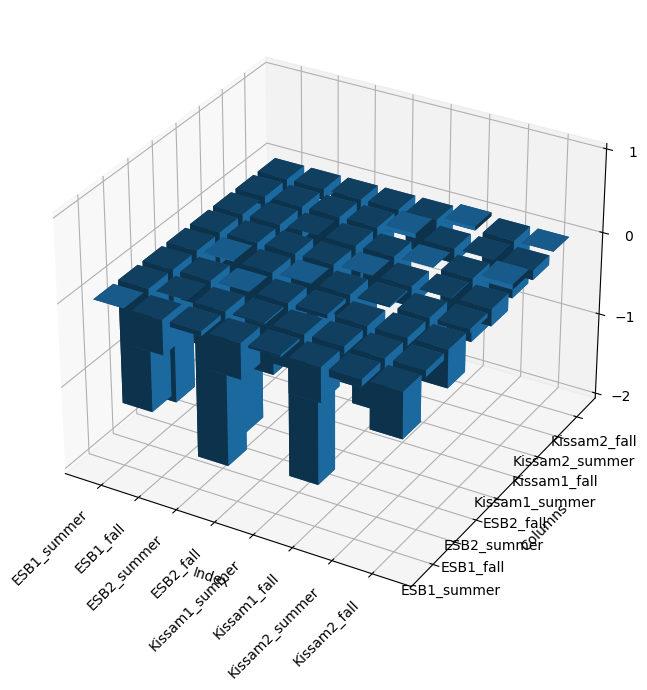

In [128]:
df = pir_df
index_labels = keys

# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Create numeric indices for x and y axes
x_indices = np.arange(len(keys))
y_indices = np.arange(len(df.columns))

# Create 2D meshgrid
x, y = np.meshgrid(x_indices, y_indices)

# Flatten indices and values
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = df.values.flatten()

# Create 3D bar plot with adjusted alpha
ax.bar3d(x_flat, y_flat, np.zeros_like(z_flat), 0.8, 0.8, z_flat, shade=True)

# Set axis labels
ax.set_xlabel('Index')
ax.set_ylabel('Columns')
ax.set_zlabel('Values')

# Set tick labels
ax.set_xticks(x_indices + 0.4)
ax.set_xticklabels(keys)
ax.set_yticks(y_indices + 0.4)
ax.set_yticklabels(df.columns)
ax.set_zticks(range(-2,2))

# Rotate the x-axis labels for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Display the plot
plt.show()


In [122]:
# Create 3D bar plot using Plotly
fig = go.Figure()

# Add surface plot
fig.add_trace(go.Surface(
    z=df.values,
    x=df.columns,
    y=index_labels,
    colorscale='Viridis',  # choose a colorscale
    colorbar=dict(title='Values'),
))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Source'),
        yaxis=dict(title='Target'),
        zaxis=dict(title='PIR'),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Show the plot
fig.show()